In [1]:
from src.datasets.tabular import ADULT, BRFSS, CANDC, COMPAS, GERMAN
import os
dataset = COMPAS
output_path = 'results/' + dataset
filename = dataset + '.csv'

Below are the holistic analysis code of the experiment result.

In [17]:
#find the best config (min avg loss) of each model with its idx, cumu_loss, avg_loss, worst_avg_loss, loss_parity, group_action_parity
import pandas as pd
import os 
import json, ast
from src.datasets.tabular import ADULT, BRFSS, CANDC, COMPAS, GERMAN

dataset = CANDC
output_path = 'results/' + dataset
filename = dataset + '_summary.csv'
df = pd.read_csv(os.path.join(output_path, filename))
df = df.rename(columns = {'Unnamed: 0': 'seq_id'})
regret_model = list(set(df['model']))
best_results = []
for model_name in regret_model:
    df_select = df[df['model'] == model_name]
    #find its config
    df_select.sort_values('avg_loss', inplace = False)
    best_metric = df_select.iloc[-1]
    config = ast.literal_eval(best_metric['config'])
    if model_name == 'supervised':
        idx = 0
    else:
        idx = config['idx']
    eval_metric = {'model': model_name, 'idx': idx, 'loss': best_metric['avg_loss'], 'group_loss_parity': best_metric['loss_parity'],
                    'group_action_parity': best_metric['group_action_parity_realized'], 'ind_parity': best_metric['individual_loss_parity_realized']}
    eval_metric.update({'worst_group_loss': max([best_metric[column] for column in best_metric.index if column.startswith('avg_loss_')])})

    best_results.append(eval_metric)
df_summary2 = pd.DataFrame(best_results)
output_file = os.path.join(output_path, dataset + '_summary_best.csv')
df_summary2.to_csv(output_file, index = None)

<Figure size 20000x20000 with 0 Axes>

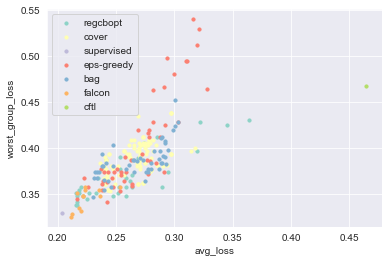

<Figure size 20000x20000 with 0 Axes>

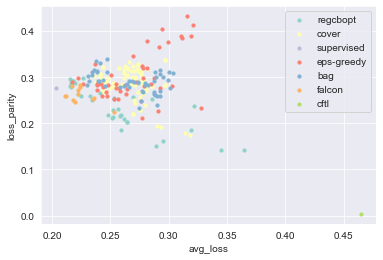

<Figure size 20000x20000 with 0 Axes>

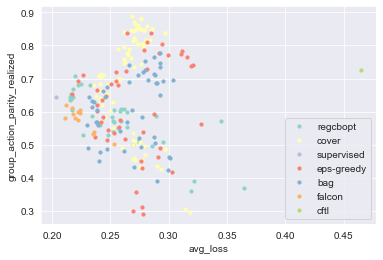

<Figure size 20000x20000 with 0 Axes>

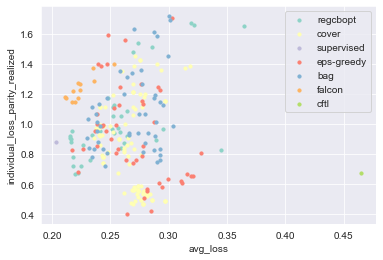

In [5]:
# scatter plot of all results showing the trend of regret and some fairness metric
import pandas as pd
import os 
import json, ast
import matplotlib.pyplot as plt
import seaborn as sns

from src.datasets.tabular import ADULT, BRFSS, CANDC, COMPAS, GERMAN
dataset = CANDC
output_path = 'results/' + dataset
filename = dataset + '_summary.csv'
df = pd.read_csv(os.path.join(output_path, filename))
num = {ADULT: 32561, COMPAS: 5771, CANDC: 1495}
def scatter(df, xname, yname):
    df = df.rename(columns = {'Unnamed: 0': 'seq_id'})
    regret_model = list(set(df['model']))
    best_results = []
    column_list = [column for column in df.columns if column.startswith('avg_loss_')]

    plt.figure(figsize = (20, 20), dpi = 1000)
    sns.set_style('darkgrid')
    df['worst_group_loss'] = df.loc[:, column_list].T.max()

    # color list: https://gist.github.com/jsundram/6004447
    df['individual_loss_parity_realized'] = df['individual_loss_parity_realized']  * num[dataset]
    df_select  = df[df['model'] == regret_model[0]]

    color_list = ["#8dd3c7","#ffffb3","#bebada","#fb8072","#80b1d3","#fdb462","#b3de69","#fccde5"]
    #["#ffffe5","#f7fcb9","#d9f0a3","#addd8e","#78c679","#41ab5d","#238443","#005a32"]
    ax0 = df_select.plot.scatter(x = xname, y = yname, s = 10,
                                color = color_list[0], label = regret_model[0])
    for i, model_name in enumerate(regret_model[1:]):
        df_select = df[df['model'] == model_name]
        
        ax0 = df_select.plot.scatter(x = xname, y = yname, s = 10,
                                    color = color_list[i + 1], label = model_name, ax = ax0)
    plt.savefig('results/figures/' + dataset + '/tradeoff_' + yname + '.pdf')
## Figure 1: loss vs worst-group loss
scatter(df, 'avg_loss', 'worst_group_loss')
## Figure 2: loss vs loss_parity
scatter(df, 'avg_loss', 'loss_parity')
scatter(df, 'avg_loss', 'group_action_parity_realized')
## Figure 3: loss vs ind-parity
scatter(df, 'avg_loss', 'individual_loss_parity_realized')


In [50]:
max([best_metric[column] for column in best_metric.index if column.startswith('avg_loss_')])

0.2719307395431313

Below are the individual analysis step of each algorithm.

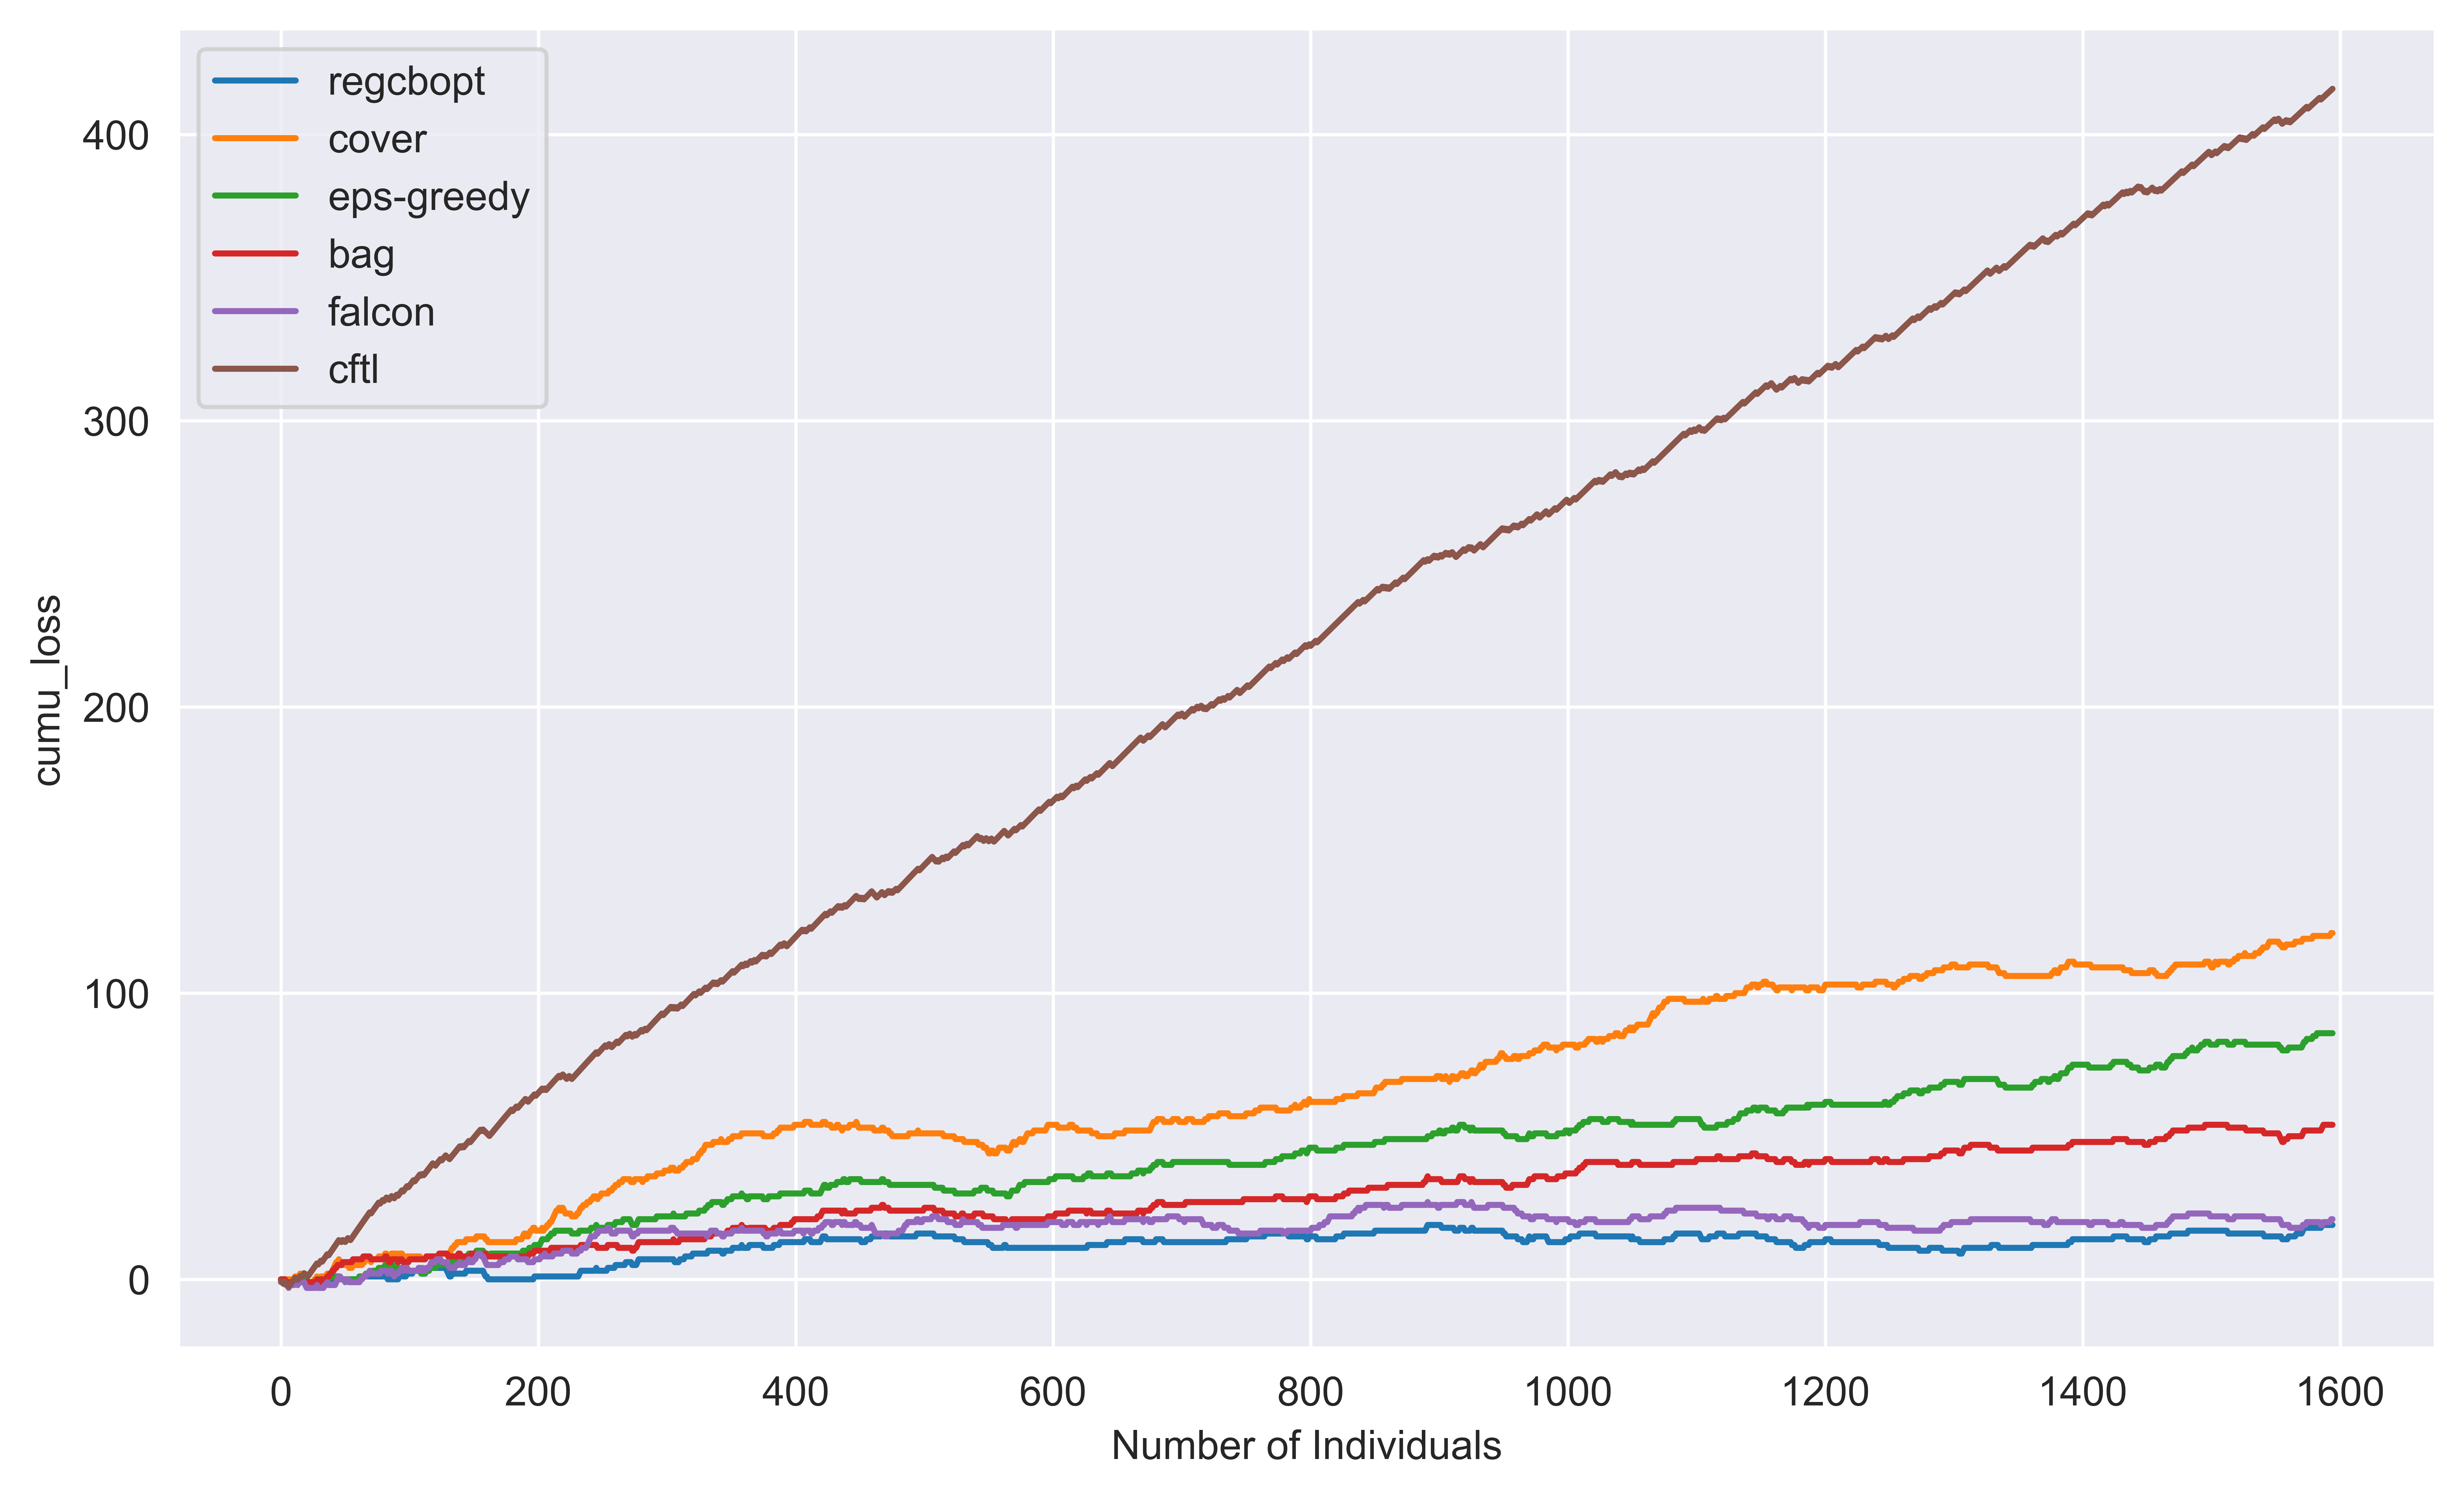

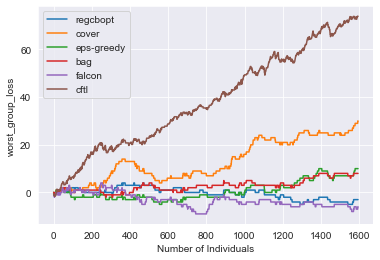

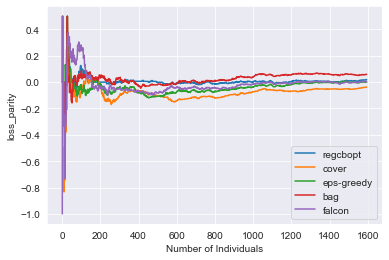

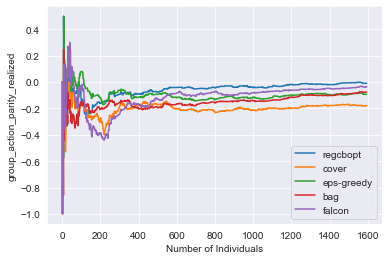

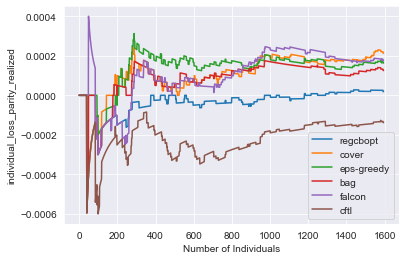

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from src.datasets.tabular import ADULT, BRFSS, CANDC, COMPAS, GERMAN
dataset = CANDC

output_path = 'results/' + dataset
filename = dataset + '_summary.csv'
metric_list = ['cumu_loss', 'worst_group_loss', 'loss_parity', 'group_action_parity_realized', 'individual_loss_parity_realized']
idx = 0
df = pd.read_csv(os.path.join(output_path, dataset + '_summary_best.csv'))

method_list = ['supervised'] + list(df['model'])
idx_list = [0] + list(df['idx'])
plt.figure(figsize = (10, 6), dpi = 1000)
sns.set_style('darkgrid')

for metric in metric_list:
    for i in range(len(method_list)):
        
        filename = dataset + '_' + method_list[i] + '_' + str(idx_list[i]) + '.csv'
        df = pd.read_csv(os.path.join(output_path, filename))
        df = df.rename(columns = {'Unnamed: 0': 'time'})
        if metric == 'worst_group_loss':
            loss_list = [column for column in df.columns if column.startswith('cumu_loss_')]
            df[metric] = df.loc[:,loss_list].T.max()
        elif metric in ['loss_parity', 'group_action_parity_realized']:
            if method_list[i] == 'cftl':
                continue
        else:
            pass
        if method_list[i] == 'supervised':
            base = df[metric]
            continue
        if metric == 'individual_loss_parity_realized':
            result = [element for i, element in enumerate(list(df[metric]))]
        else:
            result = list(df[metric])
        plt.plot(list(df['time']), list(np.array(result) - np.array(base)), label = method_list[i])
        plt.savefig('results/figures/' + dataset + '/time_' + metric + '.pdf')
    plt.xlabel('Number of Individuals')


    plt.ylabel(metric)
    plt.legend()
    #plt.savefig()
    plt.show()
# if metric == 'worst_group_loss':
#     pass

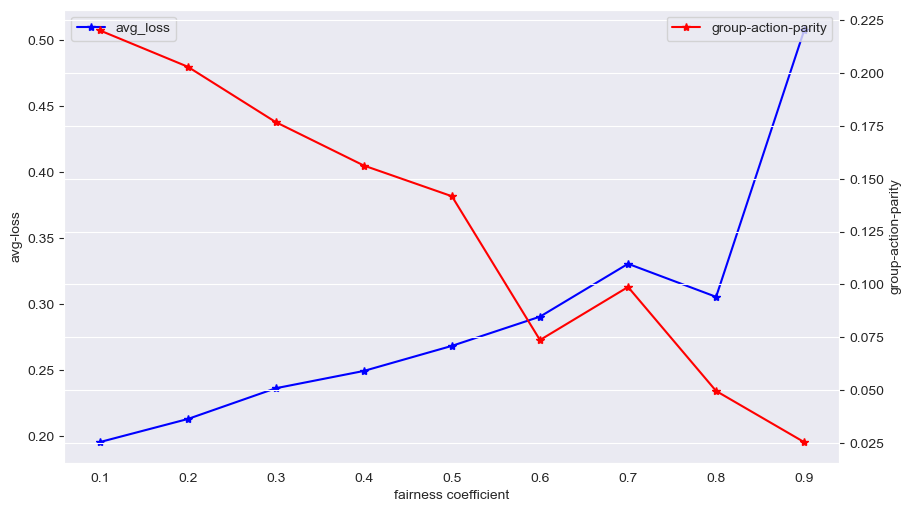

In [15]:
# SHOW THE TREND FOR REGRET W.R.T. UNFAIRNESS individual-parity, group-action-parity
from src.datasets.tabular import ADULT, BRFSS, CANDC, COMPAS, GERMAN
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
dataset = ADULT
output_path = 'results/' + dataset
fair_type = 'group-action-parity'
fair_label_dict = {'individual-parity': 'individual_loss_parity_realized', 
                    'group-action-parity': 'group_action_parity_realized'}
filename = dataset + '_summary_' + fair_type + '.csv'
df = pd.read_csv(os.path.join(output_path, filename))
fig = plt.figure(figsize = (10, 6), dpi = 100)
sns.set_style('darkgrid')
ax = fig.add_subplot(111)
ax.grid()
ax.plot(df['ind_parity'], df['avg_loss'], color = 'blue', marker = '*', label = 'avg_loss')
ax.legend(loc = 'upper left')

ax2 = ax.twinx()
ax2.plot(df['ind_parity'], df[fair_label_dict[fair_type]], color = 'red', marker = '*', label = fair_type)
ax.set_xlabel('fairness coefficient')
ax.set_ylabel('avg-loss')
ax2.set_ylabel(fair_type)
ax2.legend(loc = 'upper right')

plt.show()



In [ ]:
#computation of avg price of fair / price of loss

In [87]:
#show the aggregated result of imposing worst group loss constraint
from src.datasets.tabular import ADULT, BRFSS, CANDC, COMPAS, GERMAN
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
dataset = COMPAS
output_path = 'results/' + dataset

filename = dataset + '_summary_loss_linear.csv'
df = pd.read_csv(os.path.join(output_path, filename))
# fig = plt.figure(figsize = (10, 6), dpi = 100)
# sns.set_style('darkgrid')
num = {ADULT: 32561, COMPAS: 5771}
df['individual_loss_parity_realized'] = df['individual_loss_parity_realized'] * num[dataset]

column_list = [column for column in df.columns if column.startswith('avg_loss_')]
df['worst_group_loss'] = df.loc[:, column_list].T.max()
df = df.fillna(0)
df.groupby(['gamma', 'fair_loss_type'])[['avg_loss', 'loss_parity', 'worst_group_loss', 'individual_loss_parity_realized']].mean()



avg_loss  loss_parity  worst_group_loss  \
gamma fair_loss_type                                                   
50    0                      0.343347     0.044094          0.352426   
      history-group-weight   0.345374     0.039174          0.355015   
      history-group-weight2  0.344412     0.047655          0.353650   
      minmax-weight          0.373454     0.050551          0.386654   
100   0                      0.333833     0.042905          0.342624   
      history-group-weight   0.332135     0.039059          0.340705   
      history-group-weight2  0.333461     0.040890          0.342491   
      minmax-weight          0.364287     0.054375          0.376582   
150   0                      0.328930     0.036469          0.336480   
      history-group-weight   0.329943     0.038089          0.338754   
      history-group-weight2  0.329094     0.042555          0.338031   
      minmax-weight          0.362381     0.054698          0.373732   
200   0                      0.326694     0.039492          0.335112   
      history-group-weight   0.327422     0.037574          0.336068   
      history-group-weight2  0.327708     0.034332          0.336435   
      minmax-weight          0.359470     0.046752          0.370620   
250   0                      0.325377     0.037992          0.333809   
      history-group-weight   0.325083     0.035567          0.333000   
      history-group-weight2  0.325213     0.041331          0.333990   
      minmax-weight          0.357027     0.052910          0.367715   
300   0                      0.324450     0.036435          0.332420   
      history-group-weight   0.324164     0.036588          0.332715   
      history-group-weight2  0.324520     0.039848          0.333589   
      minmax-weight          0.358257     0.055348          0.368642   

                             individual_loss_parity_realized  
gamma fair_loss_type                                          
50    0                                             290.8900  
      history-group-weight                          291.2785  
      history-group-weight2                         290.6020  
      minmax-weight                                 244.7190  
100   0                                             276.4450  
      history-group-weight                          277.8480  
      history-group-weight2                         279.0210  
      minmax-weight                                 227.0190  
150   0                                             270.7565  
      history-group-weight                          272.7300  
      history-group-weight2                         273.1460  
      minmax-weight                                 220.1100  
200   0                                             269.3890  
      history-group-weight                          269.0695  
      history-group-weight2                         269.3840  
      minmax-weight                                 218.1440  
250   0                                             266.1480  
      history-group-weight                          266.5870  
      history-group-weight2                         267.4950  
      minmax-weight                                 214.4960  
300   0                                             264.1450  
      history-group-weight                          265.5635  
      history-group-weight2                         266.6760  
      minmax-weight                                 214.3130

In [88]:
df.groupby(['gamma', 'fair_loss_type'])[['avg_loss', 'loss_parity', 'worst_group_loss', 'individual_loss_parity_realized']].std()/3.3

avg_loss  loss_parity  worst_group_loss  \
gamma fair_loss_type                                                   
50    0                      0.001044     0.003618          0.001278   
      history-group-weight   0.001316     0.002573          0.001401   
      history-group-weight2  0.001329     0.004511          0.001499   
      minmax-weight          0.001248     0.003224          0.001590   
100   0                      0.001100     0.002678          0.001274   
      history-group-weight   0.000978     0.002649          0.001270   
      history-group-weight2  0.001078     0.002363          0.001613   
      minmax-weight          0.000962     0.003163          0.001188   
150   0                      0.000647     0.002945          0.001098   
      history-group-weight   0.000727     0.002194          0.001079   
      history-group-weight2  0.000908     0.002635          0.000793   
      minmax-weight          0.000739     0.003024          0.001320   
200   0                      0.000877     0.002321          0.001184   
      history-group-weight   0.000871     0.001626          0.001163   
      history-group-weight2  0.000920     0.002713          0.001204   
      minmax-weight          0.000906     0.003127          0.001443   
250   0                      0.000742     0.002167          0.000911   
      history-group-weight   0.001006     0.001932          0.001249   
      history-group-weight2  0.000740     0.002105          0.001026   
      minmax-weight          0.000725     0.002340          0.001060   
300   0                      0.000547     0.001963          0.000794   
      history-group-weight   0.000667     0.002048          0.000919   
      history-group-weight2  0.000860     0.001694          0.000860   
      minmax-weight          0.000917     0.002706          0.001039   

                             individual_loss_parity_realized  
gamma fair_loss_type                                          
50    0                                             0.747722  
      history-group-weight                          0.558362  
      history-group-weight2                         0.605181  
      minmax-weight                                 0.920543  
100   0                                             0.748785  
      history-group-weight                          0.731950  
      history-group-weight2                         0.774263  
      minmax-weight                                 0.890364  
150   0                                             0.557374  
      history-group-weight                          0.481616  
      history-group-weight2                         0.370778  
      minmax-weight                                 1.020865  
200   0                                             0.607131  
      history-group-weight                          0.526772  
      history-group-weight2                         0.685565  
      minmax-weight                                 0.706374  
250   0                                             0.559762  
      history-group-weight                          0.539482  
      history-group-weight2                         0.586216  
      minmax-weight                                 0.409818  
300   0                                             0.448125  
      history-group-weight                          0.453040  
      history-group-weight2                         0.757685  
      minmax-weight                                 0.377508

<Figure size 20000x20000 with 0 Axes>

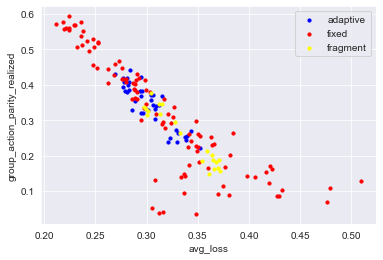

In [30]:
from src.datasets.tabular import ADULT, BRFSS, CANDC, COMPAS, GERMAN
import os
import pandas as pd
dataset = CANDC
output_path = 'results/' + dataset
action_type = 'group-action-parity'

map_action = {'group-action-parity': 'group_action_parity_realized', 'individual-parity': 'individual_loss_parity_realized'}
filename = dataset + '_summarynew_' + action_type + '.csv'
import json, ast
#set the base case
df = pd.read_csv(os.path.join(output_path, filename))


#scatter plot
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (20, 20), dpi = 1000)
sns.set_style('darkgrid')
color_list = ["#8dd3c7","#ffffb3","#bebada","#fb8072","#80b1d3","#fdb462","#b3de69","#fccde5"]
num = {ADULT: 32561, COMPAS: 5771, CANDC: 1495}
df['individual_loss_parity_realized'] = df['individual_loss_parity_realized'] * num[dataset]

df_select = df.query('ind_parity in ["linear", "quad", "log", "cube"]')
df_raw = df.query('ind_parity not in ["linear", "quad", "log", "cube", "test", "test2"]')
df_new = df.query('ind_parity in ["test", "test2"]')
ax0 = df_select.plot.scatter(x = 'avg_loss', y = map_action[action_type], s = 10,
                                color = 'blue', label = 'adaptive')
ax0 = df_raw.plot.scatter(x = 'avg_loss', y = map_action[action_type], s = 10,
                                color = 'red', label = 'fixed', ax = ax0)

ax0 = df_new.plot.scatter(x = 'avg_loss', y = map_action[action_type], s = 10,
                                color = 'yellow', label = 'fragment', ax = ax0)

plt.savefig('results/figures/' + dataset + '/falcon_tradeoff_' + action_type + '.pdf')


In [28]:
#temp code for debug use, add data from adult_new feature_param to the _summary file
import pandas as pd

df_all = pd.read_csv('results/adult/adult_summarynew_group-action-parity.csv')
feature_param = ['linear', 'quad', 'log', 'cube']
for idx in range(10):
    for feature in feature_param:
        df_append = pd.read_csv('results/adult/adult_new/adult_group-action-parity_' + feature + '_' + str(idx) + '.csv')
        df_append = pd.DataFrame(df_append.iloc[-1:])
        
        df_append['gamma'], df_append['fair_type'], df_append['ind_parity'] = 100, 'group-action-parity', feature
        df_append['avg_loss'] = df_append['cumu_loss'] / float(sum([df_append['cumu_num_' + str(i)] for i in range(4)]))
        for i in range(4):
            df_append['avg_loss_' + str(i)] = df_append['cumu_loss_' + str(i)] / df_append['cumu_num_' + str(i)]
        df_append = df_append.drop(columns = ['Unnamed: 0', 'group', 'action', 'step_loss', 'cumu_num_0', 'cumu_num_1', 'cumu_num_2', 'cumu_num_3'])

        df_all = pd.concat([df_all, df_append])

df_all.to_csv('results/adult/adult_summarynew_group-action-parity2.csv', index = None)
        

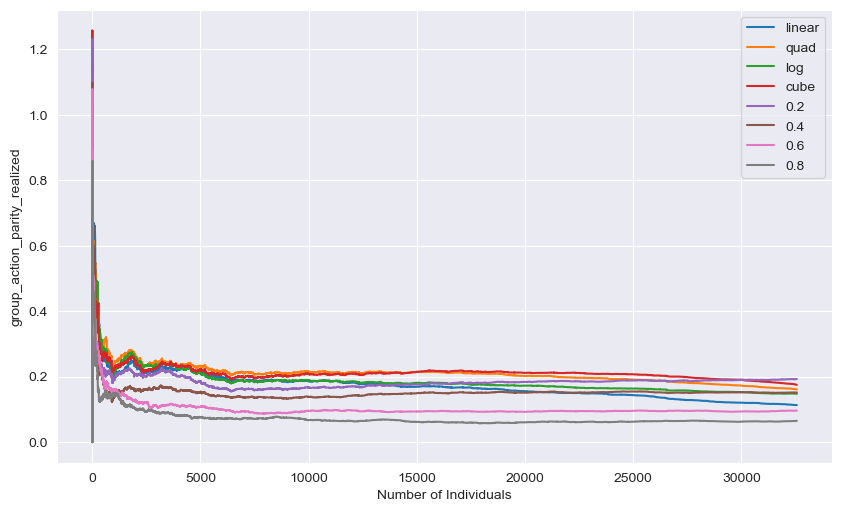

In [42]:
# aggregated version of regret-plot figure
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from src.datasets.tabular import ADULT, BRFSS, CANDC, COMPAS, GERMAN
dataset = ADULT

output_path = 'results/adult/adult_new/' 
filename = dataset + '_summary.csv'
action_type = 'group-action-parity'
metric = 'group_action_parity_realized'
idx = 0
feature_name = 'linear'


plt.figure(figsize = (10, 6), dpi = 100)
sns.set_style('darkgrid')



for feature_name in ['linear', 'quad', 'log', 'cube', 0.2, 0.4, 0.6, 0.8]:
    result = 0
    for idx in range(10):
        filename = dataset + '_' + action_type + '_' + str(feature_name) + '_' + str(idx) + '.csv'
        df = pd.read_csv(os.path.join(output_path, filename))
        df = df.rename(columns = {'Unnamed: 0': 'time'})
        if metric == 'worst-group-loss':
            loss_list = [column for column in df.columns if column.startswith('cumu_loss_')]
            df[metric] = df.loc[:,loss_list].T.max()
        elif metric in ['cumu_loss', 'loss_parity', 'group_action_parity_realized', 'individual_loss_parity_realized']:
            pass
        else:
            pass
        result += np.array(list(df[metric]))/10
        
        if metric == 'individual-parity':
            new_result = [element * (i + 1) for i, element in enumerate(result)]
        else:
            new_result = result
    plt.plot(list(df['time']), list(new_result), label = str(feature_name))
plt.xlabel('Number of Individuals')
plt.ylabel(metric)
plt.legend()
#plt.savefig()
plt.show()